In [322]:
%matplotlib  inline

import matplotlib.pyplot as pp
import numpy
import pandas
import geopandas
import csv
import shapely.geometry as shp
from shapely.geometry import Point
from scipy.spatial import cKDTree
import mapclassify
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


pandas.options.display.max_rows = 24

# creio que os seguintes sao desnecessarios:
#import matplotlib
#import shapefile
#import seaborn

from pointpats import PointPattern, PoissonPointProcess, as_window

#from pointpats.distance_statistics import G, F, J, K, L, Genv, Fenv, Jenv, Kenv, Lenv
#import pysal as lp
#import scipy.spatial
#import libpysal as ps
#from pySpacell import Spacell

#import sklearn.cluster as skc
#import sklearn.metrics as skm

#import rasterio as rio
#import contextility as ctx

In [2]:
portugal_geo = geopandas.read_file('../Recursos/Mapas/EGM_2019_SHP_20190312/DATA/Countries/PT/NUTS_3.shp', index=False)
autonomas = portugal_geo[(portugal_geo['NUTS_LABEL'] == 'Região Autónoma dos Açores') | (portugal_geo['NUTS_LABEL'] == 'Região Autónoma da Madeira')].index
portugal_cont = portugal_geo.drop(index=autonomas) #excluir as regioes autonomas
portugal = portugal_cont.to_crs(epsg=3763)
portugal_poligono = portugal.unary_union #serve para testar que todas as coordenadas das escolas e restaurantes estão dentro de PT

In [3]:
urbanas_geo = geopandas.read_file('../Recursos/Mapas/EGM_2019_SHP_20190312/DATA/Countries/PT/BuiltupA.shp', index=False)
urbanas = urbanas_geo.to_crs(epsg=3763)
urbanas = urbanas[urbanas['geometry'].intersects(portugal_poligono) == True] #excluir as regioes autonomas
urbanas = urbanas[['geometry']]
urbanas_poligono = urbanas.unary_union
# Nota: como parte dos poligonos das urbanas ultrapassam ligeiramente o bordo do poligono portugal,
#tenho que usar .intersects e não .within

In [4]:
vilas_geo = geopandas.read_file('../Recursos/Mapas/EGM_2019_SHP_20190312/DATA/Countries/PT/BuiltupP.shp', index=False)
vilas = vilas_geo.to_crs(epsg=3763)
vilas = vilas[vilas['geometry'].within(portugal_poligono) == True] #excluir as regioes autonomas
vilas = vilas[['NAMA1','geometry']].rename({'NAMA1':'Nome'}, axis =1) #manter apenas info relevante

In [5]:
escolas_original = pandas.read_csv('../Recursos/Listas/Lista_Escolas_2.1.csv', sep = ';', index_col=False)
geometry_escolas = [Point(xy) for xy in zip(escolas_original['Lon'], escolas_original['Lat'])]
escolas_geo = geopandas.GeoDataFrame(escolas_original, geometry=geometry_escolas, crs='EPSG:4258') #confirmar epsg dce origem
escolas_crs = escolas_geo.to_crs(epsg=3763)
escolas_crs[escolas_crs['geometry'].within(portugal_poligono) == False] #testar coordenadas erradas

,Nome,Lat,Lon,DISTRITO,GRUPONATUREZA,ENSINOS,geometry


In [6]:
mcd_original = pandas.read_csv('../Recursos/Listas/Lista_McDonalds.csv', sep = ';', index_col=False)
geometry_mcd = [Point(xy) for xy in zip(mcd_original['Lon'], mcd_original['Lat'])]
mcd_geo = geopandas.GeoDataFrame(mcd_original, geometry=geometry_mcd, crs='EPSG:4258') #nao deveria ser 3857? retirado do gmaps, right?
mcd_crs = mcd_geo.to_crs(epsg=3763)
mcd_crs[mcd_crs['geometry'].within(portugal_poligono) == False]

,Tipo,Nome,Lat,Lon,geometry


In [7]:
tel_original = pandas.read_csv('../Recursos/Listas/Lista_Telepizzas.csv', sep = ';', index_col=False)
geometry_tel = [Point(xy) for xy in zip(tel_original['Lon'], tel_original['Lat'])]
tel_geo = geopandas.GeoDataFrame(tel_original, geometry=geometry_tel, crs='EPSG:4258') #nao deveria ser 3857? retirado do gmaps, right?
tel_crs = tel_geo.to_crs(epsg=3763)
tel_crs[tel_crs['geometry'].within(portugal_poligono) == False]

,Tipo,Nome,Lat,Lon,geometry


In [8]:
bk_original = pandas.read_csv('../Recursos/Listas/Lista_BK_2.1.csv', sep = ';', index_col=False)
geometry_bk = [Point(xy) for xy in zip(bk_original['Lon'], bk_original['Lat'])]
bk_geo = geopandas.GeoDataFrame(bk_original, geometry=geometry_bk, crs='EPSG:4258') #nao deveria ser 3857? retirado do applemaps, right?
bk_crs = bk_geo.to_crs(epsg=3763)
bk_crs[bk_crs['geometry'].within(portugal_poligono) == False]

,Tipo,Nome,Lat,Lon,geometry


In [9]:
#acrescentar NUT correspondente na base de dados das escolas e dos restaurantes
escolas = geopandas.sjoin(portugal, escolas_crs, op='contains', how='right')[['Nome', 'Lat', 'Lon', 'NUTS_LABEL', 'geometry']].sort_values(by='NUTS_LABEL').reset_index(drop=True)
bk = geopandas.sjoin(portugal, bk_crs, op='contains', how='right')[['Tipo','Nome', 'Lat', 'Lon','NUTS_LABEL', 'geometry']].sort_values(by='NUTS_LABEL').reset_index(drop=True)
mcd = geopandas.sjoin(portugal, mcd_crs, op='contains', how='right')[['Tipo','Nome', 'Lat', 'Lon','NUTS_LABEL', 'geometry']].sort_values(by='NUTS_LABEL').reset_index(drop=True)
tel = geopandas.sjoin(portugal, tel_crs, op='contains', how='right')[['Tipo','Nome', 'Lat', 'Lon','NUTS_LABEL', 'geometry']].sort_values(by='NUTS_LABEL').reset_index(drop=True)

#  NOTA: aqui, a referência tem que ser sempre 'right' para ir buscar as coordenadas dos pontos 
#  (e não as coordenadas dos poligonos dos NUTs), pois esta operação so guarda uma geometria

#criar variável com todos os 3 tipos de restaurantes
rest = pandas.concat([mcd, bk, tel], ignore_index=True).sort_values(by='NUTS_LABEL').reset_index(drop=True)


# agregar escolas e restaurantes por NUT para poder fazer choropleth
escolas_nut = geopandas.sjoin(portugal, escolas_crs, op='contains', how='left')[['Nome', 'NUTS_LABEL', 'geometry']].dissolve(by='NUTS_LABEL', aggfunc='count').reset_index().rename({'Nome': 'count'}, axis=1)
bk_nut = geopandas.sjoin(portugal, bk_crs, op='contains', how='left')[['Nome','NUTS_LABEL', 'geometry']].dissolve(by='NUTS_LABEL', aggfunc='count').reset_index().rename({'Nome': 'count'}, axis=1)
mcd_nut = geopandas.sjoin(portugal, mcd_crs, op='contains', how='left')[['Nome', 'NUTS_LABEL', 'geometry']].dissolve(by='NUTS_LABEL', aggfunc='count').reset_index().rename({'Nome': 'count'}, axis=1)
tel_nut = geopandas.sjoin(portugal, tel_crs, op='contains', how='left')[['Nome','NUTS_LABEL', 'geometry']].dissolve(by='NUTS_LABEL', aggfunc='count').reset_index().rename({'Nome': 'count'}, axis=1)
rest_nut = geopandas.sjoin(portugal, rest.drop(columns='NUTS_LABEL'), op='contains', how='left')[['Nome','NUTS_LABEL', 'geometry']].dissolve(by='NUTS_LABEL', aggfunc='count').reset_index().rename({'Nome': 'count'}, axis=1)

#  NOTA: aqui, a referência já tem que ser sempre 'left' para ir buscar as coordenadas dos polígonos dos NUTs

In [10]:
# confirmar se há coordenadas iguais, o que há, porque escolas de ensinos diferentes e, como tal, com 
# nomes diferentes podem estar no mesmo edifício

#escolas[escolas['geometry'].duplicated(keep=False)] 

In [11]:
#forma alternativa de converter df em gdf: 
#df['Coordinates']  = list(zip(df.Longitude, df.Latitude))
#df['Coordinates'] = df['Coordinates'].apply(Point)
#gdf = geopandas.GeoDataFrame(df, geometry='Coordinates')

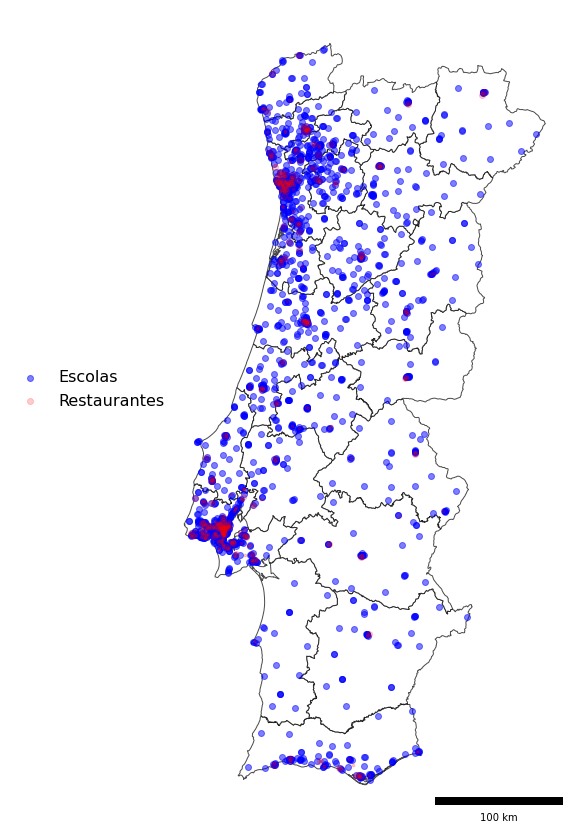

In [320]:
#grafico DEPOIS de mudar as coordenadas para UTM com unidades em metros
fig, ax = pp.subplots(nrows=1, ncols=1, figsize=(15, 15))

ax.set_axis_off()
portugal.plot(ax=ax, edgecolor='k', alpha= 0.7, facecolor='white', figsize=(15,15))
escolas.plot(ax=ax, color='blue', alpha=0.5, label='Escolas')
bk.plot(ax=ax, color='red', alpha= 0.2, label ='Restaurantes')
mcd.plot(ax=ax, color='red', alpha=0.2, markersize=7)
tel.plot(ax=ax, color='red', alpha= 0.2, markersize=7)
ax.legend(fontsize=16,
         loc=(-0.4, 0.5),
         frameon=False)

scalebar = ScaleBar(dx=1, length_fraction=0.4, location='lower right', color='black',sep=7, pad=0, border_pad=0)
pp.gca().add_artist(scalebar)



#pp.title('urbanas', fontweight='bold')



#tirar os eixos mas manter um background cor diferente
#ax.set_facecolor((0, 0, 0, 0.05))
#ax.set_axis_off()
#ax.add_artist(ax.patch)
#ax.patch.set_zorder(-1)



#grafico1.set(xlim=(-100000, -80000), ylim=(-115000,-95000)) #lisboa 


#grafico1.set(xlim=(-150000, 170000), ylim=(-310000,285000))
#grafico1.set(xlim=(-130000, -55000), ylim=(-150000,-50000)) #lisboa 
#grafico1.set(xlim=(-60000, 0), ylim=(140000,180000)) #porto

#teste pontos
#grafico1.set(xlim=(-60000, 0), ylim=(90000,180000))
#escolas.loc[[0], 'geometry'].plot(ax=grafico1, color='blue', alpha=1, markersize=15)
#rest.loc[[1], 'geometry'].plot(ax=grafico1, color='black', alpha=1)

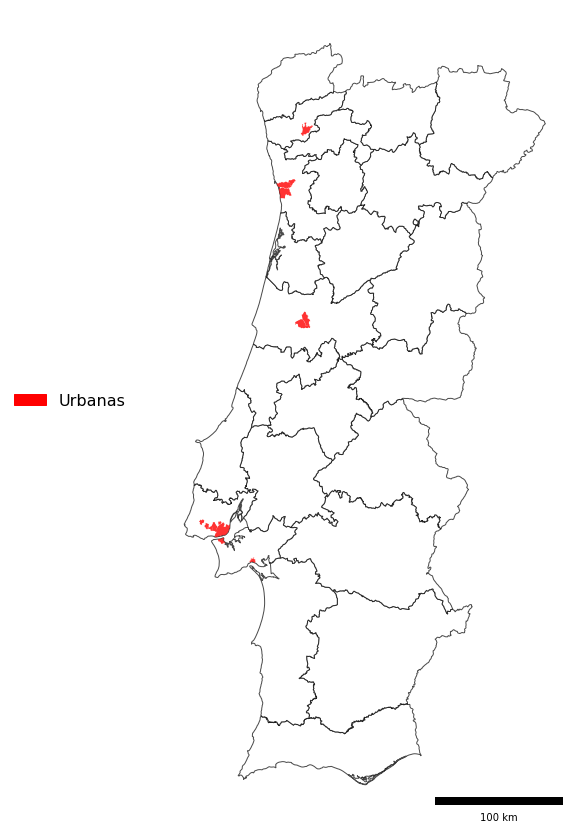

In [297]:
fig, ax = pp.subplots(nrows=1, ncols=1, figsize=(15, 15))

ax.set_axis_off()
portugal.plot(ax=ax, edgecolor='k', alpha= 0.7, facecolor='white', figsize=(15,15))
urbanas.plot(ax=ax, color='red', alpha=0.8)

#Not all handles can be turned into legend entries automatically, so it is often necessary to create an artist which can
#ver em https://matplotlib.org/tutorials/intermediate/legend_guide.html
red_patch = mpatches.Patch(color='red', label='Urbanas')


ax.legend(handles=[red_patch],
          fontsize=16,
         loc=(-0.4, 0.5),
         frameon=False)

scalebar = ScaleBar(dx=1, length_fraction=0.4, location='lower right', color='black',sep=7, pad=0, border_pad=0)
pp.gca().add_artist(scalebar)

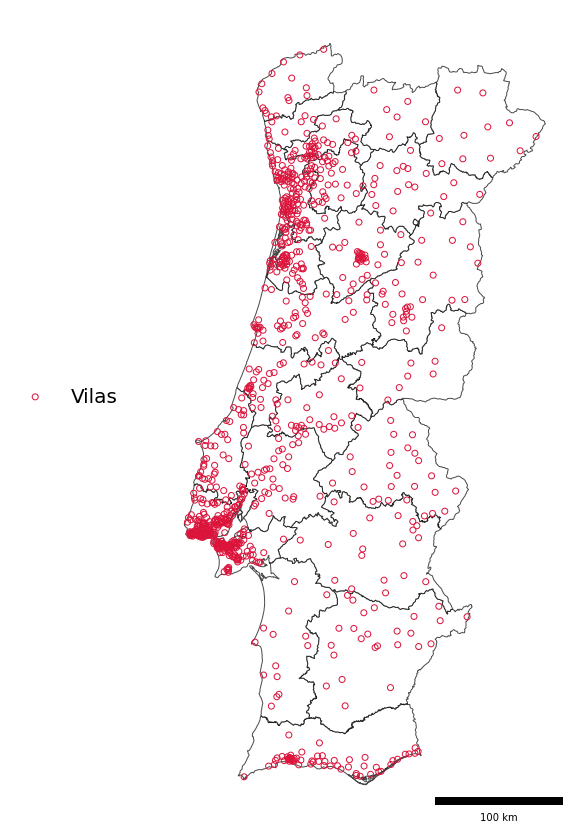

In [321]:
fig, ax = pp.subplots(nrows=1, ncols=1, figsize=(15, 15))

ax.set_axis_off()
portugal.plot(ax=ax, edgecolor='k', alpha= 0.7, facecolor='white', figsize=(15,15))
vilas.plot(ax=ax, color='crimson', facecolor='none', label='Vilas')
ax.legend(fontsize=20,
         loc=(-0.4, 0.5),
         frameon=False)

scalebar = ScaleBar(dx=1, length_fraction=0.4, location='lower right', color='black',sep=7, pad=0, border_pad=0)
pp.gca().add_artist(scalebar)

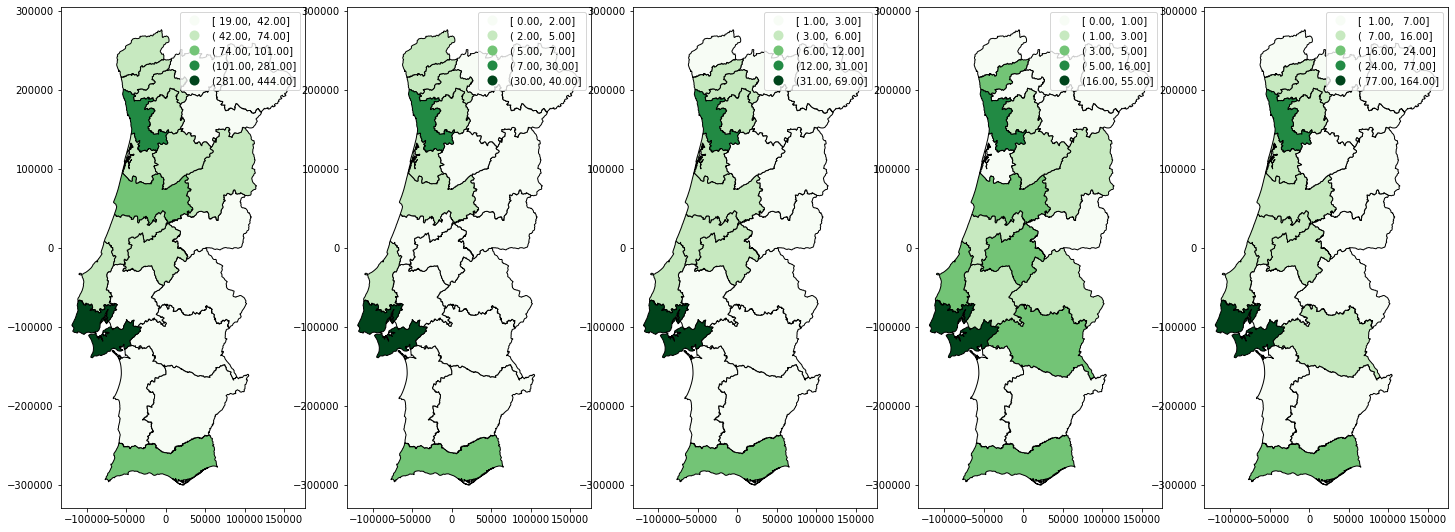

In [14]:
#distribuiçao nacional das escolas e de cada restaurante, por NUT
fig, (g2, g3, g4, g5, g6) = pp.subplots(nrows=1, ncols=5, figsize=(20, 16))
pp.tight_layout()

grafico2 = escolas_nut.plot(ax=g2, column='count', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico3 = bk_nut.plot(ax=g3, column='count', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico4 = mcd_nut.plot(ax=g4, column='count', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico5 = tel_nut.plot(ax=g5, column='count', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico6 = rest_nut.plot(ax=g6, column='count', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')

<h1></h1>
<h1>OBJECTIVO 1</h1>
<h2>Determinar, para cada escola em Portugal continental, qual a proximidade ao estabelecimento de fast-food (EFF) mais próximo</h2>

In [15]:
#mudei os nomes das entradas para Capitalized
#acrescentei o tipo de rest nos csv dos mcd e tel
#padronizei os labels das colunas
#comparei visualmente no mapa para ver se batia certo


#retirado de https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe

def ckdnearest(gdA, gdB):
    nA = numpy.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = numpy.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pandas.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pandas.Series(dist, name='dist')], axis=1)
    gdf['dist'] = gdf['dist'] / 1000  #conversao de m para km
    return gdf

prox = ckdnearest(escolas.drop(columns=['Lat', 'Lon']).rename({'Nome':'ESCOLA'}, axis =1), rest.drop(columns=['Lat', 'Lon', 'NUTS_LABEL']))

In [16]:
# agregar escolas e restaurantes por NUT para poder fazer choropleth
# criar as estatisticas por NUTs

prox_mean = geopandas.sjoin(portugal, prox.drop(columns=['NUTS_LABEL']), op='contains', how='left')[['NUTS_LABEL','geometry','ESCOLA','Nome','dist']].dissolve(by='NUTS_LABEL', aggfunc='mean').reset_index().rename({'dist': 'mean'}, axis=1)
prox_median = geopandas.sjoin(portugal, prox.drop(columns=['NUTS_LABEL']), op='contains', how='left')[['NUTS_LABEL','geometry','ESCOLA','Nome','dist']].dissolve(by='NUTS_LABEL', aggfunc='median').reset_index().rename({'dist': 'median'}, axis=1)
prox_min = geopandas.sjoin(portugal, prox.drop(columns=['NUTS_LABEL']), op='contains', how='left')[['NUTS_LABEL','geometry','dist']].dissolve(by='NUTS_LABEL', aggfunc='min').reset_index().rename({'dist': 'min'}, axis=1)
prox_max = geopandas.sjoin(portugal, prox.drop(columns=['NUTS_LABEL']), op='contains', how='left')[['NUTS_LABEL','geometry','dist']].dissolve(by='NUTS_LABEL', aggfunc='max').reset_index().rename({'dist': 'max'}, axis=1)

prox_nut = prox_mean.merge(prox_min.drop(columns='geometry'), on='NUTS_LABEL').merge(prox_median.drop(columns='geometry'), on='NUTS_LABEL').merge(prox_max.drop(columns='geometry'), on='NUTS_LABEL')

In [62]:
prox_nut

,NUTS_LABEL,geometry,mean,min,median,max
0,Alentejo Central,"POLYGON ((-1073.526 -71605.437, -630.371 -7280...",11.940714,0.200635,0.948901,52.376782
1,Alentejo Litoral,"POLYGON ((-44110.184 -124081.441, -42077.713 -...",27.542112,0.840066,34.796923,45.382582
2,Algarve,"MULTIPOLYGON (((45606.039 -283262.555, 45754.0...",5.226242,0.165932,1.453336,40.700967
3,Alto Alentejo,"POLYGON ((39933.927 -2304.062, 40567.682 -3672...",11.200635,0.210226,10.757003,30.384528
4,Alto Minho,"POLYGON ((-5179.204 275699.799, -4976.613 2750...",6.950883,0.166367,3.453004,20.667286
5,Alto Tâmega,"POLYGON ((19106.418 250829.093, 19456.503 2508...",14.145333,1.027745,18.436686,31.468839
6,Ave,"POLYGON ((1135.844 224425.278, 1691.638 224251...",4.555859,0.263459,2.180750,20.574689
7,Baixo Alentejo,"POLYGON ((-793.279 -150229.221, 188.370 -15046...",27.384600,0.433639,29.068979,77.168128
8,Beira Baixa,"POLYGON ((86794.102 73381.912, 87591.769 72972...",12.697925,0.376681,1.486138,36.213921
9,Beiras e Serra da Estrela,"MULTIPOLYGON (((68306.969 150077.750, 69381.69...",16.424590,0.316303,16.180568,47.808008


In [48]:
@interact
def show_articles_more_than(column=['median', 'min'], x=(0, 35, 1)):
    return prox_nut.loc[prox_nut[column] < x]

interactive(children=(Dropdown(description='column', options=('median', 'min'), value='median'), IntSlider(val…

In [58]:
%matplotlib inline


<Figure size 432x288 with 0 Axes>

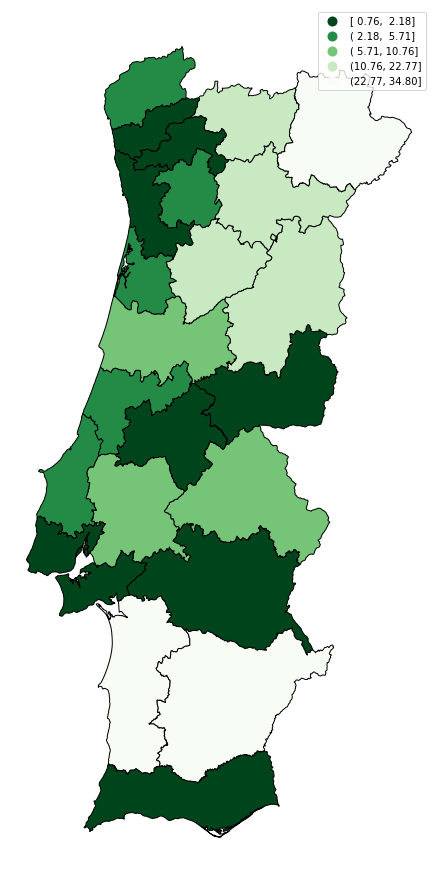

In [59]:
#fig, (g7, g8, g9) = pp.subplots(nrows=1, ncols=3, figsize=(20, 16))
#usamos a mediana pois ha outliers
pp.tight_layout()

grafico7 = prox_nut.plot(column='median', figsize=(20,16), legend=True, scheme='FisherJenks', cmap='Greens_r', edgecolor='k')
grafico7.set_axis_off()
#grafico8 = prox_nut.plot(ax=g8, column='min', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens_r', edgecolor='k')
#grafico9 = prox_nut.plot(ax=g9, column='max', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens_r', edgecolor='k')
#fig.canvas.toolbar_visible = False
#fig.canvas.header_visible = False
#fig.canvas.resizable = True

In [35]:
#seaborn.distplot(prox_nut['min'], rug=True)

<h1></h1>
<h1>OBJECTIVO 2</h1>
<h2>Determinar, para cada escola em Portugal continental, quantos EFF estão a curta distância (raios de 5 e de 10min a pé)</h2>

In [20]:
# Para cada escola, criar um raio de 400m e de 800m e contar quantos rest estão nesse círculos
i = 0
raio = escolas[:]  # slice op para copiar o conteúdo e não linkar à variável antiga
raio['400m'] = ''  # criar novas duas colunas vazias
raio['800m'] = ''

for i in range(len(escolas)):
    raio.loc[i,'400m'] = len(rest[rest['geometry'].within(escolas['geometry'][i].buffer(400))])
    raio.loc[i,'800m'] = len(rest[rest['geometry'].within(escolas['geometry'][i].buffer(800))])

raio

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Nome,Lat,Lon,NUTS_LABEL,geometry,400m,800m
0,Escola Básica e Secundária Dr. Isidoro de Sous...,38.338320,-8.008283,Alentejo Central,POINT (10913.158 -147636.468),0,0
1,"Escola Básica de Alcáçovas, Viana do Alentejo",38.390293,-8.150032,Alentejo Central,POINT (-1478.535 -141874.527),0,0
2,"Escola Secundária Públia Hortênsia de Castro, ...",38.780050,-7.425084,Alentejo Central,POINT (61523.380 -98370.585),0,0
3,"Escola Básica D. João IV, Vila Viçosa",38.781654,-7.425807,Alentejo Central,POINT (61459.178 -98193.006),0,0
4,"Escola Básica Diogo Lopes Sequeira, Alandroal",38.705110,-7.403481,Alentejo Central,POINT (63466.886 -106675.114),0,0
...,...,...,...,...,...,...,...
1807,IPTA - Instituto Profissional de Tecnologias A...,41.149452,-8.603119,Área Metropolitana do Porto,POINT (-39455.037 164581.952),1,2
1808,Lycée Français Marius Latour de Porto,41.157360,-8.659819,Área Metropolitana do Porto,POINT (-44209.421 165487.438),0,1
1809,Oporto British School - Instituto Cultural Bri...,41.152610,-8.674150,Área Metropolitana do Porto,POINT (-45415.576 164967.291),0,0
1810,"Externato ""Nossa Senhora do Perpétuo Socorro""",41.162702,-8.602640,Área Metropolitana do Porto,POINT (-39406.891 166053.246),0,0


In [63]:
# agregar dados raio por NUT para poder fazer choropleth
# soma
raio_nut = geopandas.sjoin(portugal, raio.drop(columns=['NUTS_LABEL']), op='contains', how='left')[['NUTS_LABEL','geometry','Nome','400m','800m']].dissolve(by='NUTS_LABEL', aggfunc='sum').reset_index()


# média de restaurantes no raio especificado para as escolas de cada NUT
raio_mean = geopandas.sjoin(portugal, raio.drop(columns=['NUTS_LABEL']), op='contains', how='left')[['NUTS_LABEL','geometry','400m','800m']]
raio_mean[['400m', '800m']] = raio_mean[['400m', '800m']].apply(pandas.to_numeric) # por algum motivo que desconheço, estas colunas aparecem como objectos e impossibilitam a obtenção da média, pelo que tenho de converter em números
raio_mean = raio_mean.dissolve(by='NUTS_LABEL', aggfunc='mean').reset_index().rename({'400m': '400m_mean', '800m': '800m_mean'}, axis=1)

#juntar
raio_nut = raio_nut.merge(raio_mean.drop(columns=['geometry']), on='NUTS_LABEL')
raio_nut

,NUTS_LABEL,geometry,400m,800m,400m_mean,800m_mean
0,Alentejo Central,"POLYGON ((-1073.526 -71605.437, -630.371 -7280...",5,12,0.151515,0.363636
1,Alentejo Litoral,"POLYGON ((-44110.184 -124081.441, -42077.713 -...",0,0,0.000000,0.000000
2,Algarve,"MULTIPOLYGON (((45606.039 -283262.555, 45754.0...",8,40,0.080808,0.404040
3,Alto Alentejo,"POLYGON ((39933.927 -2304.062, 40567.682 -3672...",1,8,0.032258,0.258065
4,Alto Minho,"POLYGON ((-5179.204 275699.799, -4976.613 2750...",4,16,0.081633,0.326531
5,Alto Tâmega,"POLYGON ((19106.418 250829.093, 19456.503 2508...",0,0,0.000000,0.000000
6,Ave,"POLYGON ((1135.844 224425.278, 1691.638 224251...",4,28,0.054054,0.378378
7,Baixo Alentejo,"POLYGON ((-793.279 -150229.221, 188.370 -15046...",0,1,0.000000,0.028571
8,Beira Baixa,"POLYGON ((86794.102 73381.912, 87591.769 72972...",1,4,0.052632,0.210526
9,Beiras e Serra da Estrela,"MULTIPOLYGON (((68306.969 150077.750, 69381.69...",2,11,0.035088,0.192982


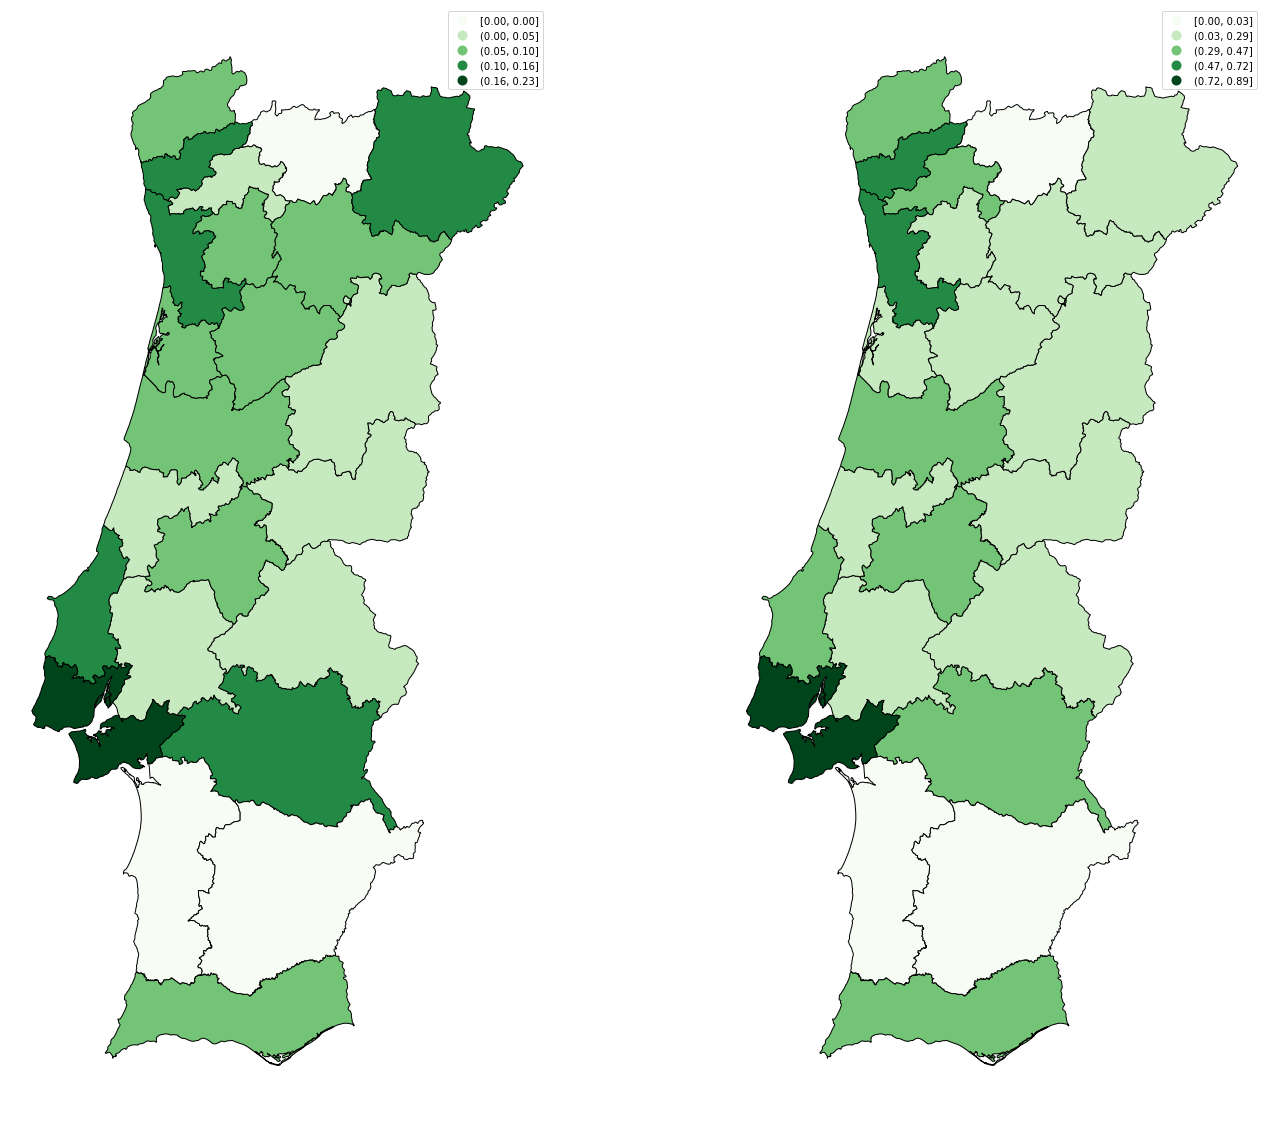

In [22]:
fig, (g12, g13) = pp.subplots(nrows=1, ncols=2, figsize=(20, 16))
#fig, (g10, g11, g12, g13) = pp.subplots(nrows=1, ncols=4, figsize=(20, 16))
pp.tight_layout()

#grafico10 = raio_nut.plot(ax=g10, column='400m', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
#grafico11 = raio_nut.plot(ax=g11, column='800m', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico12 = raio_nut.plot(ax=g12, column='400m_mean', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico13 = raio_nut.plot(ax=g13, column='800m_mean', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')

grafico12.set_axis_off()
grafico13.set_axis_off()

<h1></h1>
<h1>OBJECTIVO 3</h1>
<h2>Determinar se a localização dos EFF apresenta depêndencia espacial da localização das escolas (ou seja, se os EFFs exibem um padrão de clustering em redor das escolas)</h2>

- random mcd, bk e tel dentro dos buffers das vilas?
- ver se ha aleatoriedade ou se há tendendecia de clustering em volta das escolas estatisticamente significativa

Kcross inohomgenous nao executval no python? Tive que exportar para R
extraí as "coordenadas" da geometria para celulas à parte
exportei para shapefile
converti em ppp no R (ver https://github.com/jlevente/publications/blob/master/cross-k/calc_crossk.R)

fiz a Kcross inhomegenous com envelope:
    raio 1500m
    lambdaX = vilas_ppm (para ter em consideração a maior probabilidade de calhar junto a vilas)
    nrank=1 (para definir como min e max do envelope o n-esimo valor mínimo e o nésimo valor maximo
    global = TRUE (para homegenizar as curvas e dar um uma probabilidade?)
    correction='translation' (? resulta!)

<s>Fiz exactamente o mesmo, mas com Lcross inhomegenous, pois esta permite ter um gráfico mais facilmente interpretavel (pois tem menor variação com o r?)
Acrescentei na expressao do gráfico ".-r ~ r", para que a recta da H0 fosse horizontal (e não diagonal)</s>

Queria acrescentar as urbanas à heterogeneidade, mas sendo polígonos torna-se complicado.
Nao consigo misturar poligonos com pontos, pois ha infinitos pontos dentro de um poligono e vou distorcer a intensidade

Como tal, vou criar 2 analises de K functions: 
    uma fora das zonas urbanas, window = portugal - urbanas. tenho de retirar todos os pontos dentro das areas urbanas e so considerar os outros (atencao à aresta!!)
    a outra dentro das areas urbanas, em que window = urbanas


ver se faz diferença usar na intesnidade (lambdaX) o ppm ou a density

falta saber como fazer cloropeth disto


In [23]:
# Colocar na mesma dataframe as escolas e os restaurantes para poder passar a ppp. 
# Note-se que é necessário fazer a distinção entre os dois tipos de ponto de cada dataframe resultante, pelo que
# é necessário acrescentar o tipo para poder fazer a distincao dos pontos escolas vs restaurante no R na funcao ppp

temp_escolas = escolas.drop(columns=['Lat', 'Lon'])
temp_escolas.insert(loc=0, column='Tipo', value='escola')

# bk, mcd, tel
uniao_escolas_bk = pandas.concat([bk.drop(columns=['Lat', 'Lon']), temp_escolas], ignore_index=True).sort_values(by='Tipo').reset_index(drop=True)
uniao_escolas_mcd = pandas.concat([mcd.drop(columns=['Lat', 'Lon']), temp_escolas], ignore_index=True).sort_values(by='Tipo').reset_index(drop=True)
uniao_escolas_tel = pandas.concat([tel.drop(columns=['Lat', 'Lon']), temp_escolas], ignore_index=True).sort_values(by='Tipo').reset_index(drop=True)

# para os restaurantes no geral
# Note-se que aqui é preciso acrescentar o tipo da variável restaurante, para distinguir das escolas, e aqui
# já não importa a distinção entre diferentes tipos de restaurante

temp_rest = rest.drop(columns=['Tipo','Lat', 'Lon'])
temp_rest.insert(loc=0, column ='Tipo', value='restaurante')
uniao_escolas_rest = pandas.concat([temp_rest, temp_escolas], ignore_index=True).sort_values(by='Tipo').reset_index(drop=True)

In [56]:
uniao_escolas_rest

,Tipo,Nome,NUTS_LABEL,geometry
0,escola,"Escola Secundária de Esmoriz, Ovar",Região de Aveiro,POINT (-41189.045 144096.675)
1,escola,Escola Profissional Profitecla (Deleg.),Viseu Dão Lafões,POINT (18647.777 109783.725)
2,escola,"Escola Básica de Santa Cruz da Trapa, São Pedr...",Viseu Dão Lafões,POINT (-1102.378 122049.039)
3,escola,Escola Profissional de Carvalhais,Viseu Dão Lafões,POINT (1655.730 124204.170)
4,escola,Escola Secundária de Santa Comba Dão,Viseu Dão Lafões,POINT (245.090 82048.658)
...,...,...,...,...
2218,restaurante,McDonalds Alges,Área Metropolitana de Lisboa,POINT (-95262.922 -106960.701)
2219,restaurante,McDonalds Almada Centro,Área Metropolitana de Lisboa,POINT (-89089.783 -109337.792)
2220,restaurante,McDonalds Forum Barreiro,Área Metropolitana de Lisboa,POINT (-81937.579 -111254.358)
2221,restaurante,McDonalds Mafra,Área Metropolitana de Lisboa,POINT (-104828.167 -79834.944)


In [25]:
#verificar que tantos os restaurantes, como as escolas como as vilas ou estão dentro ou fora das areas urbanas, 
#de forma a não perder os que poderiam estar nas bordas

for a in (vilas, uniao_escolas_bk, uniao_escolas_mcd, uniao_escolas_tel, uniao_escolas_rest):
    print(len(a[a.within(urbanas_poligono)]) + len(a[a.disjoint(urbanas_poligono)]) == len(a))

True
True
True
True
True


In [26]:
#separar dentro das areas urbanas vs fora
uniao_escolas_rest_urbanas = uniao_escolas_rest[uniao_escolas_rest.within(urbanas_poligono)]
uniao_escolas_rest_rural = uniao_escolas_rest[uniao_escolas_rest.disjoint(urbanas_poligono)]

vilas_urbanas = vilas[vilas.within(urbanas_poligono)]
vilas_rural = vilas[vilas.disjoint(urbanas_poligono)]

In [27]:
# Extração das coordenadas x e y da geometria dos pontos (note-se que estão em CRS diferente das lat e lon originais!)

def extrair_xy(lista):
    x = [x for x,y in zip(lista['geometry'].x, lista['geometry'].y)]
    y = [y for x,y in zip(lista['geometry'].x, lista['geometry'].y)]
    lista.insert(loc=len(lista.columns), column='x', value=x)
    lista.insert(loc=len(lista.columns), column='y', value=y)
    
extrair_xy(uniao_escolas_bk)
extrair_xy(uniao_escolas_mcd)
extrair_xy(uniao_escolas_tel)

extrair_xy(vilas_urbanas)
extrair_xy(vilas_rural)
extrair_xy(uniao_escolas_rest_urbanas)
extrair_xy(uniao_escolas_rest_rural)

In [28]:
#pt_sem_urbanas
rural = portugal[:][['NUTS_LABEL','geometry']]
rural['geometry'] = portugal.difference(urbanas_poligono)

In [29]:
# exportar para shapefile a ser lida n R
portugal[['NUTS_LABEL', 'geometry']].to_file('shapefiles/portugal.shp', driver='ESRI Shapefile')
rural.to_file('shapefiles/rural.shp', driver='ESRI Shapefile')
urbanas.to_file('shapefiles/urbanas.shp', driver='ESRI Shapefile')

vilas_urbanas.to_file('shapefiles/vilas_urbanas.shp', driver='ESRI Shapefile')
vilas_rural.to_file('shapefiles/vilas_rural.shp', driver='ESRI Shapefile')

uniao_escolas_bk.to_file('shapefiles/bk.shp', driver='ESRI Shapefile')
uniao_escolas_mcd.to_file('shapefiles/mcd.shp', driver='ESRI Shapefile')
uniao_escolas_tel.to_file('shapefiles/tel.shp', driver='ESRI Shapefile')
uniao_escolas_rest.to_file('shapefiles/rest.shp', driver='ESRI Shapefile')
uniao_escolas_rest_rural.to_file('shapefiles/rest_rural.shp', driver='ESRI Shapefile')
uniao_escolas_rest_urbanas.to_file('shapefiles/rest_urbanas.shp', driver='ESRI Shapefile')